# 2020 Arrests

## Jessica Melendez & Sam Guerrero

For this week's assignment we will conduct a spatial autocorrelation analysis of arrest data to better understand where there are significant areas of clustering and see what that analysis tells us about arrest data between West LA and South LA. 

First, let's import our libraries for this analysis

In [1]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Let's try this spatial autocorrelation again, but this time let's look at data during the pandemic from its onset in March 2020 up until December 2020, just before Los Angeles became the epicenter.

In [2]:
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
gdf_tracts = gpd.read_file('data/tracts.geojson')

In [4]:
gdf = gpd.read_file('data/acs2019_5yr_B01003_15000US060372672002.geojson')

<AxesSubplot:>

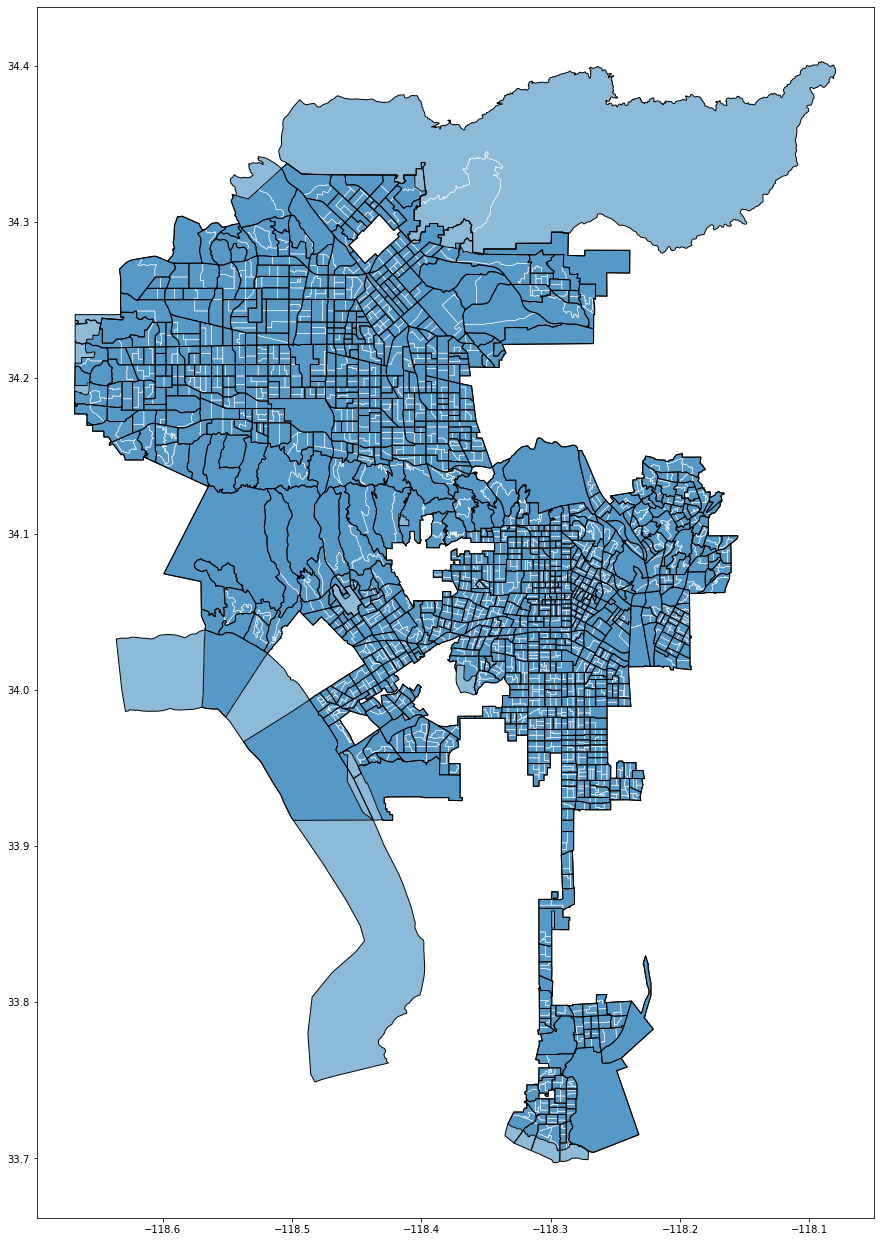

In [5]:
fig,ax = plt.subplots(figsize=(15,80))

# blue background of census tracts
gdf_tracts.plot(ax=ax,zorder=10,alpha=0.5)
# alpha is transparency

# while lines to show block groups (sandwiched between the two layers above for visual clarity)
gdf.boundary.plot(ax=ax,color='white',zorder=15,lw=0.5)
# drawing not filling in

# black boundary lines of census tracts on top of everything
gdf_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=1)

In [6]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             2516 non-null   object  
 1   name              2516 non-null   object  
 2   B01003001         2516 non-null   float64 
 3   B01003001, Error  2516 non-null   float64 
 4   geometry          2516 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 98.4+ KB


In [7]:
gdf = gdf[['geoid','B01003001','geometry']]

Okay, we should probably rename the columns to get a better understanding of what they represent

In [8]:
gdf.columns = ['FIPS','TotalPop','geometry']

In [9]:
gdf.tail()

FIPS   TotalPop  \
2511  15000US060379800261       26.0   
2512  15000US060379800281        0.0   
2513  15000US060379800311     1175.0   
2514  15000US060379902000        0.0   
2515       16000US0644000  3966936.0   

                                               geometry  
2511  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
2512  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
2513  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
2514  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
2515  MULTIPOLYGON (((-118.66818 34.18987, -118.6681...

In [10]:
gdf=gdf.drop(2515)

In [11]:
gdf.tail()

FIPS  TotalPop  \
2510  15000US060379800241     223.0   
2511  15000US060379800261      26.0   
2512  15000US060379800281       0.0   
2513  15000US060379800311    1175.0   
2514  15000US060379902000       0.0   

                                               geometry  
2510  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...  
2511  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
2512  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
2513  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
2514  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...

Let's clean up the FIPS code a bit...

In [12]:
gdf['FIPS'] = gdf['FIPS'].str.replace('15000US','')
gdf.tail()

FIPS  TotalPop  \
2510  060379800241     223.0   
2511  060379800261      26.0   
2512  060379800281       0.0   
2513  060379800311    1175.0   
2514  060379902000       0.0   

                                               geometry  
2510  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...  
2511  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
2512  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
2513  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
2514  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...

We should probably clean up the data a bit more so let's sort by dropping total populations of less than 100

In [13]:
gdf.sort_values(by='TotalPop').head(20)

FIPS  TotalPop  \
2514  060379902000       0.0   
2358  060372772002       0.0   
2512  060379800281       0.0   
2509  060379800231       0.0   
2506  060379800201       0.0   
2508  060379800221       0.0   
2501  060379800091       5.0   
2503  060379800141       9.0   
2511  060379800261      26.0   
2507  060379800211      33.0   
2500  060379800081      68.0   
2499  060379302002      94.0   
2502  060379800101      95.0   
2505  060379800191     138.0   
1482  060372145033     163.0   
2360  060372774002     220.0   
2510  060379800241     223.0   
1868  060372371013     288.0   
889   060371835101     329.0   
1706  060372283104     337.0   

                                               geometry  
2514  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
2358  MULTIPOLYGON (((-118.38597 33.94734, -118.3859...  
2512  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
2509  MULTIPOLYGON (((-118.64870 34.23120, -118.6480...  
2506  MULTIPOLYGON (((-118.34412 34.21700, -118.3438...  
2508  MULTIPOLYGON (((-118.50266 34.30809, -118.5026...  
2501  MULTIPOLYGON (((-118.33707 34.14160, -118.3361...  
2503  MULTIPOLYGON (((-118.26088 33.76850, -118.2602...  
2511  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
2507  MULTIPOLYGON (((-118.40183 34.26509, -118.4017...  
2500  MULTIPOLYGON (((-118.50267 34.22121, -118.5015...  
2499  MULTIPOLYGON (((-118.51028 34.34504, -118.5102...  
2502  MULTIPOLYGON (((-118.25165 34.08038, -118.2515...  
2505  MULTIPOLYGON (((-118.59919 34.07436, -118.5991...  
1482  MULTIPOLYGON (((-118.35791 34.06769, -118.3568...  
2360  MULTIPOLYGON (((-118.37868 33.95180, -118.3786...  
2510  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...  
1868  MULTIPOLYGON (((-118.29148 33.98586, -118.2914...  
889   MULTIPOLYGON (((-118.20178 34.11567, -118.2015...  
1706  MULTIPOLYGON (((-118.26855 34.01020, -118.2679...

In [14]:
gdf = gdf[gdf['TotalPop']>100]
gdf.head(20)

FIPS  TotalPop                                           geometry
0   060371011101    1688.0  MULTIPOLYGON (((-118.29133 34.26008, -118.2913...
1   060371011102    1614.0  MULTIPOLYGON (((-118.30229 34.25870, -118.3009...
2   060371011103     981.0  MULTIPOLYGON (((-118.30080 34.26327, -118.2979...
3   060371011221    2156.0  MULTIPOLYGON (((-118.30334 34.27371, -118.3033...
4   060371011222    1249.0  MULTIPOLYGON (((-118.29075 34.26906, -118.2906...
5   060371012101    3047.0  MULTIPOLYGON (((-118.29434 34.25233, -118.2931...
6   060371012102    3300.0  MULTIPOLYGON (((-118.29945 34.25598, -118.2979...
7   060371012201    1126.0  MULTIPOLYGON (((-118.28592 34.25404, -118.2859...
8   060371012202    2576.0  MULTIPOLYGON (((-118.28593 34.25227, -118.2846...
9   060371013001    1283.0  MULTIPOLYGON (((-118.27817 34.25577, -118.2781...
10  060371013002    1093.0  MULTIPOLYGON (((-118.27644 34.24561, -118.2764...
11  060371013003     887.0  MULTIPOLYGON (((-118.27403 34.24533, -118.2732...
12  060371013004     621.0  MULTIPOLYGON (((-118.27822 34.25068, -118.2782...
13  060371014001     864.0  MULTIPOLYGON (((-118.30264 34.25325, -118.3022...
14  060371014002    1354.0  MULTIPOLYGON (((-118.32238 34.24963, -118.3221...
15  060371014003    1240.0  MULTIPOLYGON (((-118.29040 34.24441, -118.2903...
16  060371021031    1763.0  MULTIPOLYGON (((-118.36533 34.22870, -118.3639...
17  060371021041    2797.0  MULTIPOLYGON (((-118.34883 34.21355, -118.3488...
18  060371021042     924.0  MULTIPOLYGON (((-118.35620 34.21971, -118.3559...
19  060371021051     951.0  MULTIPOLYGON (((-118.35307 34.20878, -118.3530...

Perfect! Let's plot this on the map now!

In [15]:
gdf = gdf.to_crs(epsg=3857)

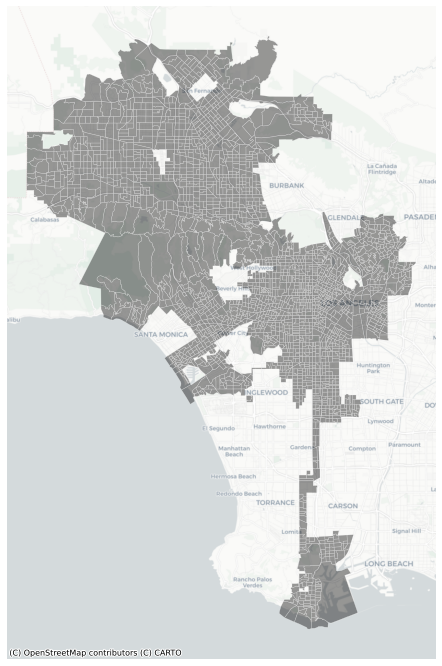

In [16]:
fig, ax = plt.subplots(figsize=(12,12))

gdf.plot(ax=ax,
         color='black', 
         edgecolor='white',
         lw=0.5,
         alpha=0.4)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Moving it along... let's plot some arrest data now! First, we should probably bring in the data from Open Data LA

In [17]:
client = Socrata("data.lacity.org", None)

results = client.get("amvf-fr72", 
                     limit=50000,
                     where = "arst_date between '2020-02-01T00:00:00' and '2020-12-31T00:00:00'",
                     order='arst_date desc')

# Convert to pandas DataFrame
arrests = pd.DataFrame.from_records(results)

Okay, so in class we brought in data from April to October of 2021 and the visualization helped us make connections to the policing of houselessness among other trends like the high concentration of arrests in more urban areas where there is a higher population of black and brown people, including South LA. For this part of our data, we want to visualize data from the beginning of the pandemic- March 2020 to December 2020 to see if the visualizations will tell us anything about the way Covid impacted arrests, or the summer uprisings, or even the spikes in cases we saw towards the end of the year last year. 

In [18]:
arrests.shape

(50000, 25)

So already we're seeing more arrests than we did when we visualized data for March-October of this year, 2021. I thought we would see less since most people were at home during the beginning of the pandemic and we also had curfews implemented during the summer uprisings. Seems like police continued with business as usual. However, we are analyzing data for an addtional 2 months as compared to what we did for arrest data between March-October 2021. 

Let's convert our pandas data into a geodataframe to start!

In [19]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

In [20]:
arrests = gpd.GeoDataFrame(arrests, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(arrests.lon, arrests.lat))

In [21]:
arrests = arrests.to_crs(epsg=3857)
print(arrests.head())

      rpt_id report_type                arst_date  time area   area_desc  \
0    6091306     BOOKING  2020-12-31T00:00:00.000  2205   13      Newton   
1  201918627         RFC  2020-12-31T00:00:00.000  1535   19     Mission   
2    5937051     BOOKING  2020-12-31T00:00:00.000  2303   07    Wilshire   
3  211404850         RFC  2020-12-31T00:00:00.000  0830   14     Pacific   
4    6090846     BOOKING  2020-12-31T00:00:00.000  1630   04  Hollenbeck   

     rd age sex_cd descent_cd  ...                                 location  \
0  1342  24      M          B  ...  3800    WOODLAWN                     AV   
1  1994  31      F          H  ...                                   WILLIS   
2  0789  14      M          B  ...  1900    5TH                          AV   
3  1411  40      M          A  ...                                     NAVY   
4  0464  37      M          B  ...   200 N  BREED                        ST   

       lat        lon                                         locati

Remember to turn out lat/lons into floats!

In [22]:
arrests.lon = arrests.lon.astype('float')
arrests.lat = arrests.lat.astype('float')

Now, let's map out this data!

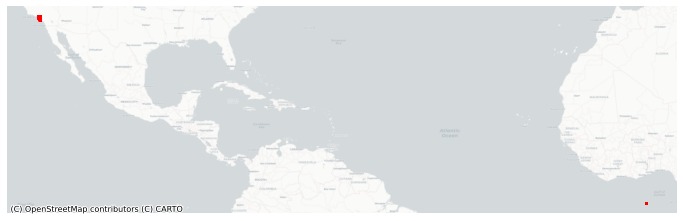

In [23]:
fig,ax = plt.subplots(figsize=(12,12))

arrests.plot(ax=ax,
             color='red',
             markersize=1)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Now, we're going to look at the unmapped rows and drop them

In [24]:
arrests[arrests.lon==0]

rpt_id report_type                arst_date  time area  area_desc  \
1      201918627         RFC  2020-12-31T00:00:00.000  1535   19    Mission   
9      201918622         RFC  2020-12-31T00:00:00.000  1600   19    Mission   
39     201918623         RFC  2020-12-31T00:00:00.000  1510   19    Mission   
43     201918624         RFC  2020-12-31T00:00:00.000  1520   19    Mission   
90     201918626         RFC  2020-12-31T00:00:00.000  1530   19    Mission   
...          ...         ...                      ...   ...  ...        ...   
49935  200608705         RFC  2020-03-14T00:00:00.000  2230   06  Hollywood   
49949  200608567         RFC  2020-03-14T00:00:00.000  1425   06  Hollywood   
49960  200608695         RFC  2020-03-14T00:00:00.000  2015   06  Hollywood   
49963  200608568         RFC  2020-03-14T00:00:00.000  2220   06  Hollywood   
49988  200608562         RFC  2020-03-14T00:00:00.000  1945   06  Hollywood   

         rd age sex_cd descent_cd  ...  \
1      1994  31      F          H  ...   
9      1983  44      M          H  ...   
39     1995  38      M          H  ...   
43     1995  45      M          H  ...   
90     1994  45      M          H  ...   
...     ...  ..    ...        ...  ...   
49935  0636  26      M          W  ...   
49949  0666  45      F          O  ...   
49960  0646  25      M          B  ...   
49963  0636  25      M          W  ...   
49988  0646  61      M          W  ...   

                                      location  lat  lon  \
1                                       WILLIS  0.0  0.0   
9              COLUMBUS                     AV  0.0  0.0   
39     7900    VAN NUYS                     BL  0.0  0.0   
43                                     CABRITO  0.0  0.0   
90             CABRITO                      RD  0.0  0.0   
...                                        ...  ...  ...   
49935  1700    VINE                         ST  0.0  0.0   
49949                                LEXINGTON  0.0  0.0   
49960                                 CHEROKEE  0.0  0.0   
49963  1700    VINE                         ST  0.0  0.0   
49988                                HOLLYWOOD  0.0  0.0   

                                     location_1 bkg_date bkg_time  \
1      {'type': 'Point', 'coordinates': [0, 0]}      NaN      NaN   
9      {'type': 'Point', 'coordinates': [0, 0]}      NaN      NaN   
39     {'type': 'Point', 'coordinates': [0, 0]}      NaN      NaN   
43     {'type': 'Point', 'coordinates': [0, 0]}      NaN      NaN   
90     {'type': 'Point', 'coordinates': [0, 0]}      NaN      NaN   
...                                         ...      ...      ...   
49935  {'type': 'Point', 'coordinates': [0, 0]}      NaN      NaN   
49949  {'type': 'Point', 'coordinates': [0, 0]}      NaN      NaN   
49960  {'type': 'Point', 'coordinates': [0, 0]}      NaN      NaN   
49963  {'type': 'Point', 'coordinates': [0, 0]}      NaN      NaN   
49988  {'type': 'Point', 'coordinates': [0, 0]}      NaN      NaN   

      bgk_location  bkg_loc_cd                            crsst  \
1              NaN         NaN                          ARMINTA   
9              NaN         NaN  PARTHENIA                    ST   
39             NaN         NaN                              NaN   
43             NaN         NaN                           WILLIS   
90             NaN         NaN  WILLIS                       AV   
...            ...         ...                              ...   
49935          NaN         NaN                              NaN   
49949          NaN         NaN                             VINE   
49960          NaN         NaN                        HOLLYWOOD   
49963          NaN         NaN                              NaN   
49988          NaN         NaN                         CHEROKEE   

                      geometry  
1      POINT (0.00000 0.00000)  
9      POINT (0.00000 0.00000)  
39     POINT (0.00000 0.00000)  
43     POINT (0.00000 0.00000)  
90     POINT (0.00000 0.00000)  
...

In [25]:
arrests = arrests[arrests.lon!=0]

Let's plot these arrests now

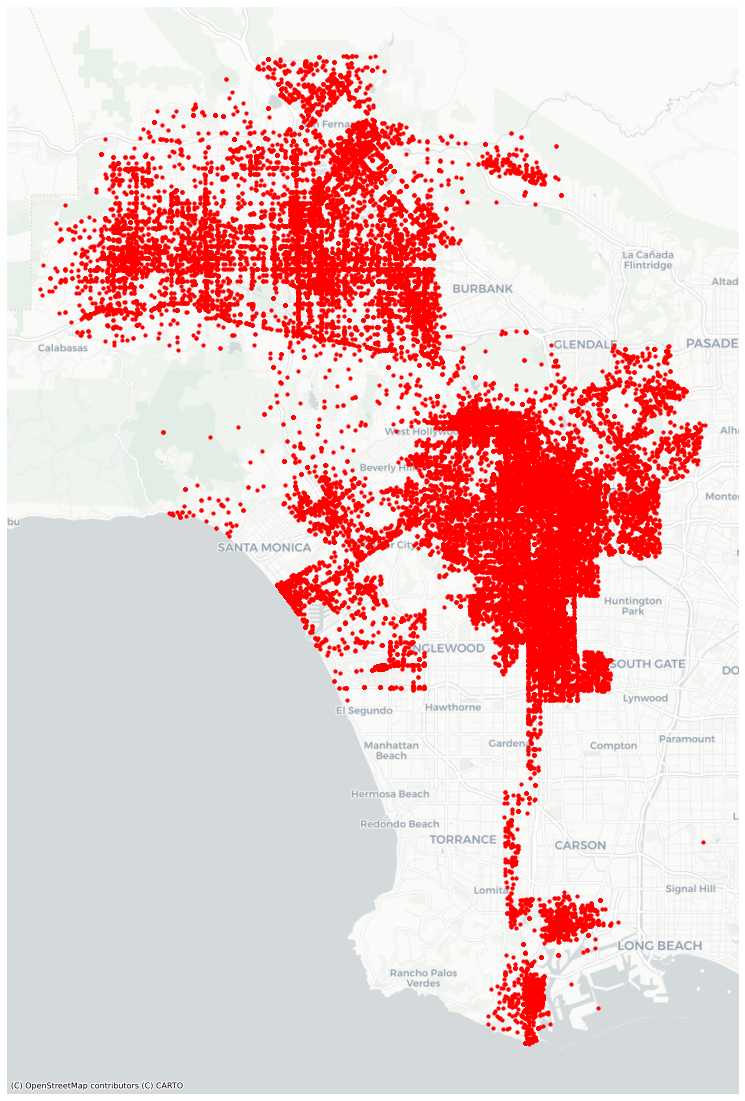

In [26]:
fig,ax = plt.subplots(figsize=(20,20))

arrests.plot(ax=ax,
             color='red',
             markersize=10)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

So we just mapped all the arrests between March 2020 to December 2020 onto by census blocks.

Now, in order to better understand the number of arrests within a census block, we should look into creating a spatial join for our data.

In [27]:
join = gpd.sjoin(arrests, gdf, how='left')
join.head()

rpt_id report_type                arst_date  time area    area_desc  \
0    6091306     BOOKING  2020-12-31T00:00:00.000  2205   13       Newton   
2    5937051     BOOKING  2020-12-31T00:00:00.000  2303   07     Wilshire   
3  211404850         RFC  2020-12-31T00:00:00.000  0830   14      Pacific   
4    6090846     BOOKING  2020-12-31T00:00:00.000  1630   04   Hollenbeck   
5  201016557         RFC  2020-12-31T00:00:00.000  1240   10  West Valley   

     rd age sex_cd descent_cd  ...  \
0  1342  24      M          B  ...   
2  0789  14      M          B  ...   
3  1411  40      M          A  ...   
4  0464  37      M          B  ...   
5  1063  28      M          W  ...   

                                          location_1                 bkg_date  \
0  {'type': 'Point', 'coordinates': [-118.2728, 3...  2020-12-31T00:00:00.000   
2  {'type': 'Point', 'coordinates': [-118.3225, 3...  2021-01-01T00:00:00.000   
3  {'type': 'Point', 'coordinates': [-118.4791, 3...                      NaN   
4  {'type': 'Point', 'coordinates': [-118.2101, 3...  2020-12-31T00:00:00.000   
5  {'type': 'Point', 'coordinates': [-118.536, 34...                      NaN   

  bkg_time           bgk_location bkg_loc_cd                            crsst  \
0     2356  METRO - JAIL DIVISION       4273                              NaN   
2     0502  METRO - JAIL DIVISION       4273                              NaN   
3      NaN                    NaN        NaN  OCEAN FRONT                  WK   
4     1825  METRO - JAIL DIVISION       4273                              NaN   
5      NaN                    NaN        NaN                              NaN   

                            geometry  index_right          FIPS TotalPop  
0  POINT (-13166067.871 4030413.447)       1744.0  060372311003   1122.0  
2  POINT (-13171600.449 4034080.277)       1573.0  060372188001   1296.0  
3  POINT (-13189033.082 4027701.020)       2275.0  060372734022    680.0  
4  POINT (-13159088.139 4034926.637)       1262.0  060372044201   2341.0  
5  POINT (-13195367.161 4051665.233)        767.0  060371394012   1833.0  

[5 rows x 29 columns]

But let's make a dataframe that counts the number of arrests by corresponding census block

In [28]:
arrests_by_gdf = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='arrests_count')

In [29]:
arrests_by_gdf.head()

FIPS  arrests_count
0  060372088011            371
1  060372077101            358
2  060372734022            340
3  060371282101            316
4  060372063003            300

Now, we should look at merging the arrest counts to the census block groups to map it!

We're going to assess the number of arrests by the total population of census groups. 

In [30]:
gdf=gdf.merge(arrests_by_gdf,on='FIPS')

In [31]:
gdf.head()

FIPS  TotalPop                                           geometry  \
0  060371011101    1688.0  MULTIPOLYGON (((-13168130.287 4063777.973, -13...   
1  060371011102    1614.0  MULTIPOLYGON (((-13169350.794 4063591.834, -13...   
2  060371011221    2156.0  MULTIPOLYGON (((-13169467.902 4065613.937, -13...   
3  060371011222    1249.0  MULTIPOLYGON (((-13168066.056 4064987.278, -13...   
4  060371012101    3047.0  MULTIPOLYGON (((-13168465.581 4062734.852, -13...   

   arrests_count  
0              2  
1             12  
2              6  
3              3  
4             24

Now, let's clean up the data a bit more and normalize it by the total number of people on a census group.

In [32]:
gdf['arrests_per_1000'] = gdf['arrests_count']/gdf['TotalPop']*1000


In [33]:
gdf.sort_values(by="arrests_per_1000").tail()

FIPS  TotalPop  \
1820  060372376001    1084.0   
1823  060372376004     924.0   
2382  060379800241     223.0   
2175  060372735022     386.0   
2171  060372734022     680.0   

                                               geometry  arrests_count  \
1820  MULTIPOLYGON (((-13167654.841 4026132.403, -13...            283   
1823  MULTIPOLYGON (((-13167410.829 4025590.204, -13...            258   
2382  MULTIPOLYGON (((-13193418.068 4053521.172, -13...             64   
2175  MULTIPOLYGON (((-13189115.569 4026857.882, -13...            133   
2171  MULTIPOLYGON (((-13189821.780 4027960.015, -13...            340   

      arrests_per_1000  
1820        261.070111  
1823        279.220779  
2382        286.995516  
2175        344.559585  
2171        500.000000

Let's try to map out a portion of this dataframe to understand the top 25 blocks with the highest amount of arrests. 

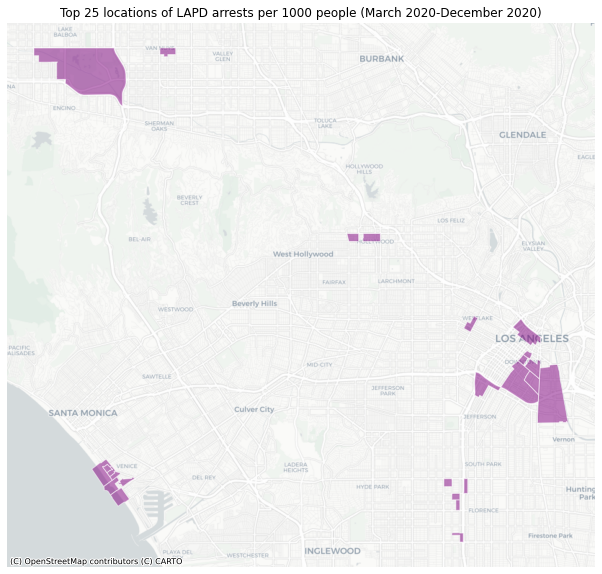

In [34]:
fig,ax = plt.subplots(figsize=(12,10))
gdf.sort_values(by='arrests_per_1000',ascending=False)[:25].plot(ax=ax,
                                                                 color='purple',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('Top 25 locations of LAPD arrests per 1000 people (March 2020-December 2020)')

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

interesting to see that this looks no different than this years data from March to October of 2021. There are still high numbers of arrests done around or exactly within the same census blocks. Are these areas just targeted by police? 

Moving on, let's bring in a chloreopath of arrests

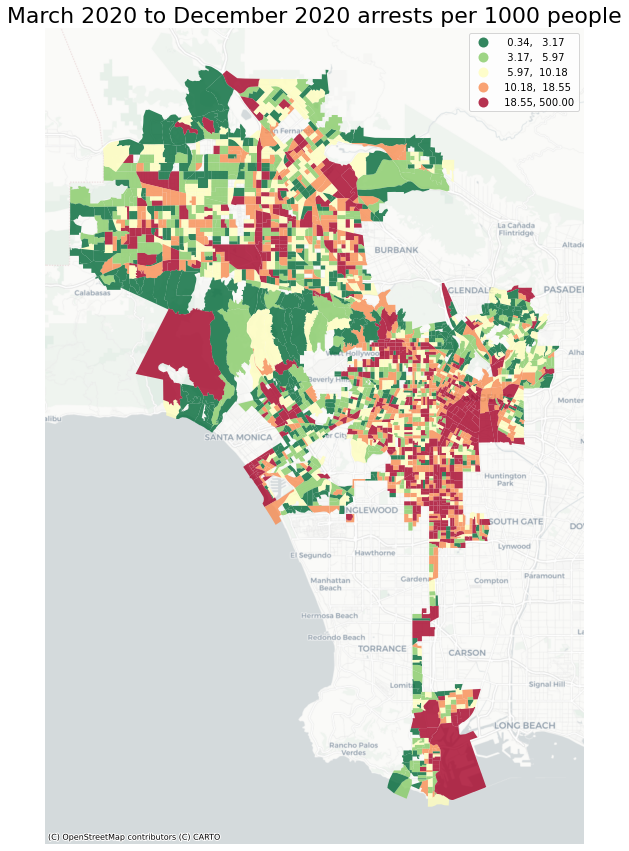

In [35]:
fig,ax = plt.subplots(figsize=(15,15))


gdf.plot(ax=ax,
        column='arrests_per_1000',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles')

ax.axis('off')
ax.set_title('March 2020 to December 2020 arrests per 1000 people',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Now, lets calulate spatial weights to better understand the areas neighborhood.

In [36]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(gdf,k=8)

# Row-standardization
wq.transform = 'r'

Now that we have our spatial weights, we use it to calculate the spatial lag.

First, let's make a new column for the spatial lag

In [37]:
gdf['arrests_per_1000_lag'] = lps.weights.lag_spatial(wq, gdf['arrests_per_1000'])

In [38]:
gdf.sample(5)[['FIPS','TotalPop','arrests_count','arrests_per_1000','arrests_per_1000_lag']]

FIPS  TotalPop  arrests_count  arrests_per_1000  \
965   060371907002     562.0             40         71.174377   
727   060371393013    1758.0             10          5.688282   
1341  060372119102    1679.0              4          2.382370   
1512  060372193002    1156.0             23         19.896194   
1884  060372397022     797.0             21         26.348808   

      arrests_per_1000_lag  
965              87.149613  
727               8.714841  
1341              6.921303  
1512             17.154295  
1884             24.725154

Alright, we've calculated arrests per 1000 and calculated the spatial lag but what does this tell us? 

Let's look at what the donut and diamont tell us...

First we have to create a column that that calculates the difference betwen arrests and lag

In [39]:
gdf['arrest_lag_diff'] = gdf['arrests_per_1000'] - gdf['arrests_per_1000_lag']

In [40]:
gdf.sort_values(by='arrest_lag_diff')

FIPS  TotalPop  \
2188  060372739022    1030.0   
1821  060372376002    1020.0   
966   060371907003     993.0   
952   060371902021    1271.0   
1822  060372376003    1073.0   
...            ...       ...   
964   060371907001    1130.0   
2175  060372735022     386.0   
1823  060372376004     924.0   
2382  060379800241     223.0   
2171  060372734022     680.0   

                                               geometry  arrests_count  \
2188  MULTIPOLYGON (((-13188028.423 4026791.427, -13...             12   
1821  MULTIPOLYGON (((-13167656.845 4025515.165, -13...             17   
966   MULTIPOLYGON (((-13173396.589 4041721.285, -13...             18   
952   MULTIPOLYGON (((-13173404.159 4042716.633, -13...             27   
1822  MULTIPOLYGON (((-13167166.705 4025522.146, -13...             24   
...                                                 ...            ...   
964   MULTIPOLYGON (((-13173138.328 4042197.304, -13...            288   
2175  MULTIPOLYGON (((-13189115.569 4026857.882, -13...            133   
1823  MULTIPOLYGON (((-13167410.829 4025590.204, -13...            258   
2382  MULTIPOLYGON (((-13193418.068 4053521.172, -13...             64   
2171  MULTIPOLYGON (((-13189821.780 4027960.015, -13...            340   

      arrests_per_1000  arrests_per_1000_lag  arrest_lag_diff  
2188         11.650485             88.602693       -76.952208  
1821         16.666667             91.862231       -75.195564  
966          18.126888             88.363356       -70.236467  
952          21.243116             87.093025       -65.849910  
1822         22.367195             86.847378       -64.480183  
...                ...                   ...              ...  
964         254.867257             47.779167       207.088090  
2175        344.559585            136.718822       207.840764  
1823        279.220779             59.042967       220.177812  
2382        286.995516              6.425407       280.570109  
2171        500.000000            110.443483       389.556517  

[2384 rows x 7 columns]

Now, let's look at data for the FIPS with highest NEGATIVE difference

In [41]:
gdf_donut = gdf.sort_values(by='arrest_lag_diff').head(1)
gdf_donut

FIPS  TotalPop  \
2188  060372739022    1030.0   

                                               geometry  arrests_count  \
2188  MULTIPOLYGON (((-13188028.423 4026791.427, -13...             12   

      arrests_per_1000  arrests_per_1000_lag  arrest_lag_diff  
2188         11.650485             88.602693       -76.952208

Perfect! Okay, now let's look at data for the FIPS with highest POSITIVE difference

In [42]:
gdf_diamond = gdf.sort_values(by='arrest_lag_diff').tail(1)
gdf_diamond

FIPS  TotalPop  \
2171  060372734022     680.0   

                                               geometry  arrests_count  \
2171  MULTIPOLYGON (((-13189821.780 4027960.015, -13...            340   

      arrests_per_1000  arrests_per_1000_lag  arrest_lag_diff  
2171             500.0            110.443483       389.556517

BRING IN THE SATELLITE IMAGERY PLEASE!!!

In [43]:
token = 'pk.eyJ1Ijoiam1lbDIxIiwiYSI6ImNrd3BwaHFndzBmMTEycXMyazZjM2J5czAifQ.EDDFydrpo4DMAzpYOceYLw'
px.set_mapbox_access_token(token)

Okay, we have to subset the donut and get the centroid now...

In [44]:
# subset donut, project to WGS84, and get its centroid
gdf_donut = gdf_donut.to_crs('epsg:4326')

# what's the centroid?
minx, miny, maxx, maxy = gdf_donut.geometry.total_bounds
center_lat_donut = (maxy-miny)/2+miny
center_lon_donut = (maxx-minx)/2+minx

Next, we have to subset the diamond and get the centroid now...

In [45]:
# subset diamond, project to WGS84, and get its centroid
gdf_diamond = gdf_diamond.to_crs('epsg:4326')

# what's the centroid?
minx, miny, maxx, maxy = gdf_diamond.geometry.total_bounds
center_lat_diamond = (maxy-miny)/2+miny
center_lon_diamond = (maxx-minx)/2+minx

Let's map it out now!

First, the donut...

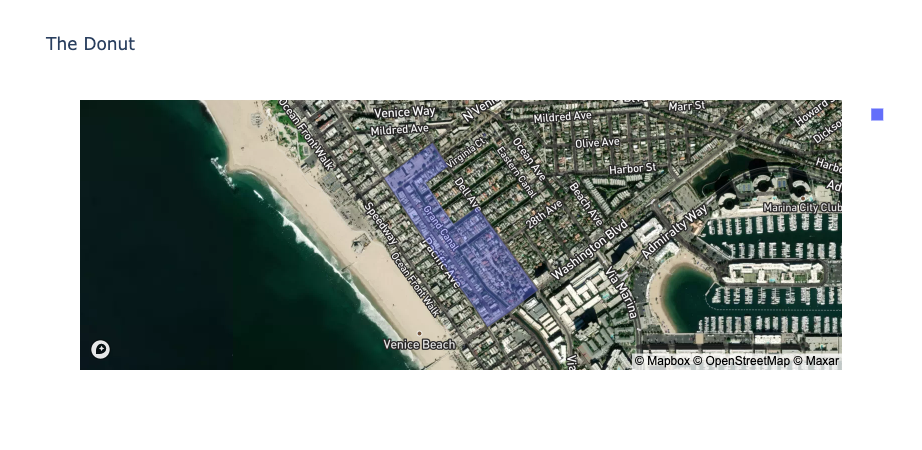

In [46]:
px.choropleth_mapbox(gdf_donut, 
                     geojson=gdf_donut.geometry, 
                     locations=gdf_donut.index, 
                     mapbox_style="satellite-streets",
                     zoom=14, 
                     center = {"lat": center_lat_donut, "lon": center_lon_donut},
                     hover_data=['FIPS','TotalPop','arrests_count','arrests_per_1000','arrests_per_1000_lag'],
                     opacity=0.4,
                     title='The Donut')

Next, the diamond...

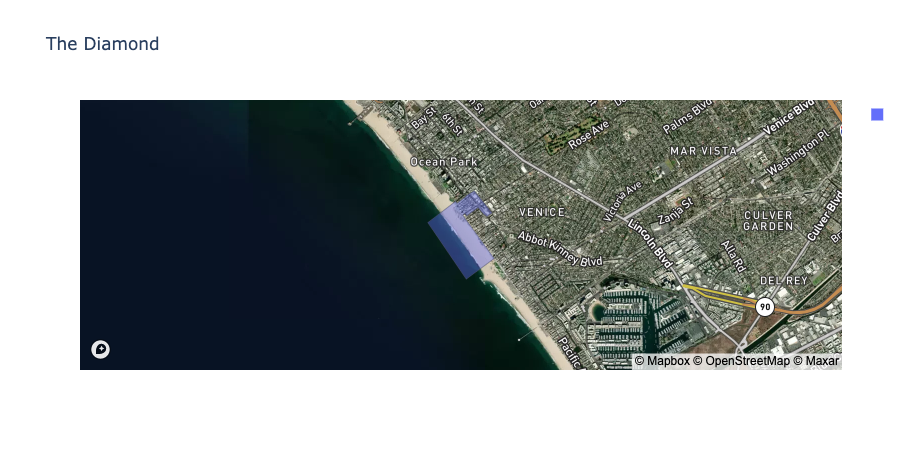

In [47]:
px.choropleth_mapbox(gdf_diamond, 
                     geojson=gdf_diamond.geometry, 
                     locations=gdf_diamond.index, 
                     mapbox_style="satellite-streets",
                     zoom=12, 
                     center = {"lat": center_lat_diamond, "lon": center_lon_diamond},
                     hover_data=['FIPS','TotalPop','arrests_count','arrests_per_1000','arrests_per_1000_lag'],
                     opacity=0.4,
                     title='The Diamond')

Interesting, here we see Venice again. The donut is located in Venice Beach, near the Venice Canal Historic District. It had an arrest rate of 11 per 1000 people and it had a spatial lag of 88!

Our diamond is once again along the Venice Beach Boardwalk. It had an arrest rate of 500 per 1000 people and it had a spatial lag of 110!!

Moving on, let's look at a spatial lag map...

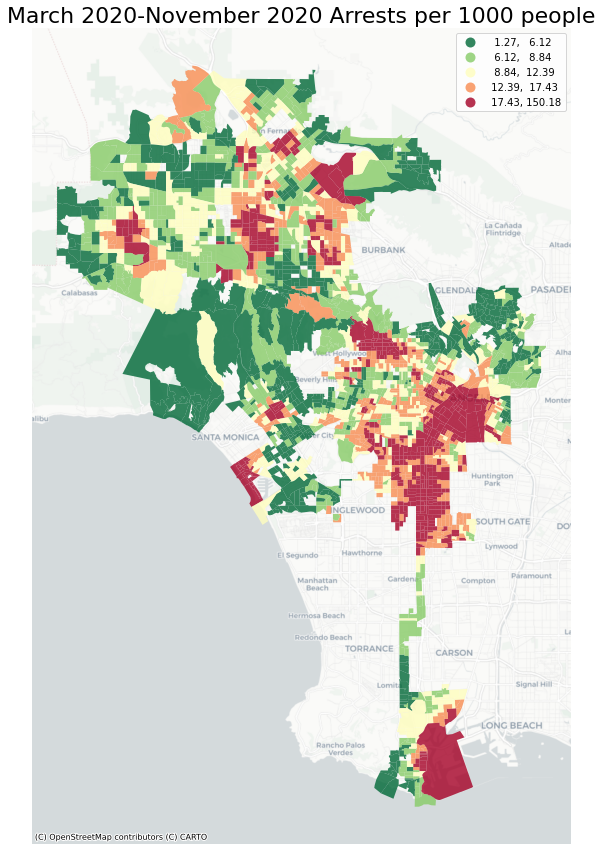

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
gdf.plot(ax=ax,
         figsize=(15,15),
         column='arrests_per_1000_lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

ax.axis('off')
ax.set_title('March 2020-November 2020 Arrests per 1000 people',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Let's compare this spatial lag map to our map of arrests per 1000

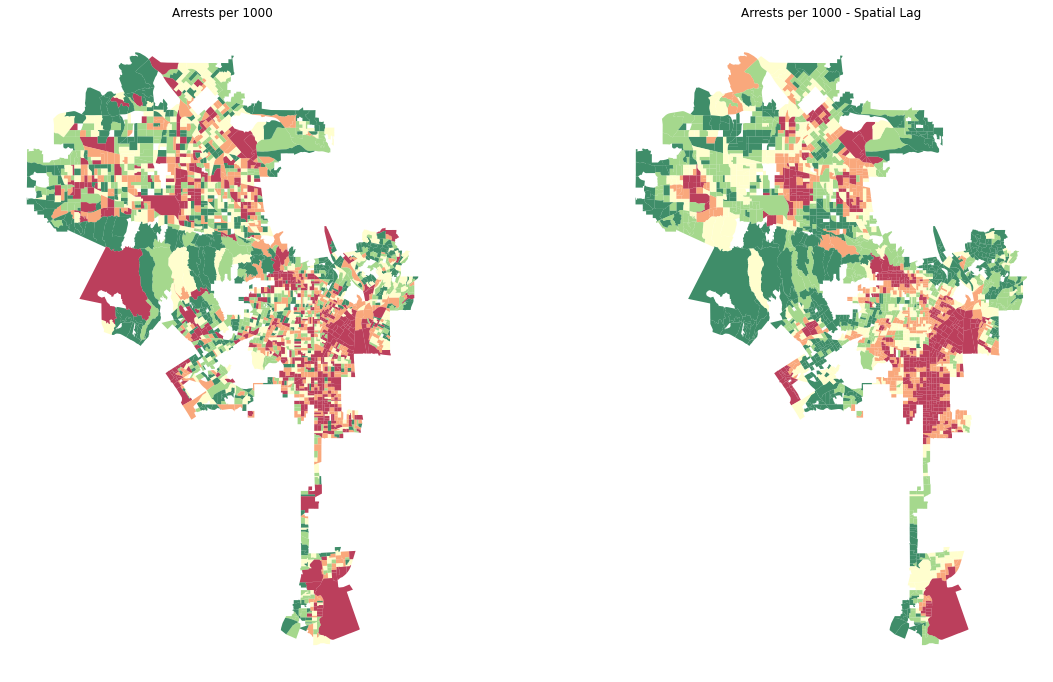

<Figure size 432x288 with 0 Axes>

In [49]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
gdf.plot(ax=ax[0], # this assigns the map to the left subplot
         column='arrests_per_1000', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Arrests per 1000")

# spatial lag map on the right
gdf.plot(ax=ax[1], # this assigns the map to the right subplot
         column='arrests_per_1000_lag', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Arrests per 1000 - Spatial Lag")

plt.show()

plt.savefig('2020arrest_data.png')

Now, let's get into the Moran's Plot to quantify the degree of the spatial correlations. To start, we test for global autocorrelation for arrest counts.But before then, let's bring in a satellite map to better understand where these clusters lie.

In [50]:
# interactive version needs to be in WGS84
gdf_web = gdf.to_crs('EPSG:4326')

In [58]:
# what's the centroid?
minx, miny, maxx, maxy = gdf_web.geometry.total_bounds
center_lat_gdf_web = (maxy-miny)/2+miny
center_lon_gdf_web = (maxx-minx)/2+minx

In [59]:
# some stats
gdf_web.arrests_per_1000_lag.describe()

count    2384.000000
mean       13.516257
std        12.560749
min         1.269596
25%         6.755138
50%        10.321366
75%        15.955689
max       150.182045
Name: arrests_per_1000_lag, dtype: float64

In [60]:
# grab the median
median = gdf_web.arrests_per_1000_lag.median()

In [63]:
fig = px.choropleth_mapbox(gdf_web, 
                     geojson=gdf_web.geometry, # the geometry column
                     locations=gdf_web.index, # the index
                     mapbox_style="satellite-streets",
                     zoom=9, 
                     color='arrests_per_1000_lag',
                     color_continuous_scale='RdYlGn_r',
                     color_continuous_midpoint =median, # put the median as the midpoint
                     range_color =(0,median*2),
                     hover_data=['FIPS','TotalPop','arrests_count','arrests_per_1000','arrests_per_1000_lag'],
                     center = {"lat": center_lat_gdf_web, "lon": center_lon_gdf_web},
                     opacity=0.8,
                     width=1000,
                     height=800,
                     labels={
                             'arrests_per_1000_lag':'Arrests per 1000 (Spatial Lag)',
                             'arrests_per_1000':'Arrests per 1000',
                     })
fig.update_traces(marker_line_width=0.1, marker_line_color='white')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("2020arrests_satmap_plotly.html")

In [51]:
y = gdf.arrests_per_1000
moran = Moran(y, wq)
moran.I

0.2828666987019176

Okay, we have a positive spatial autocorrelation of 0.282

Let's see it on a scatterplot

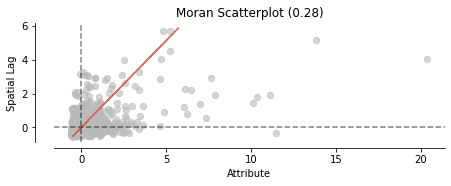

In [52]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

What does our Moran value of 0.28 mean? Essentially, how likely is our observed pattern on the map generated by an entirely random process? 
First, we need to compare our value with a simulation of 999 permutations that randomly shuffles the arrest data throughout the given geographies.

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.28', ylabel='Density'>)

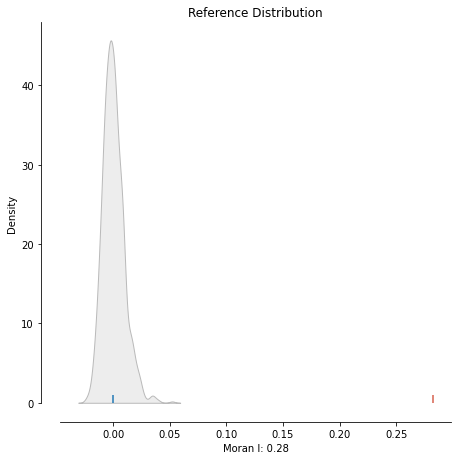

In [53]:
plot_moran_simulation(moran,aspect_equal=False)

In [54]:
moran.p_sim

0.001

Our p-value comes out to be 0.1%

Now, let's move on to our moran local values to obtain a moran local scatterplot!

In [55]:
lisa = esda.moran.Moran_Local(y, wq)

Time to plot it!

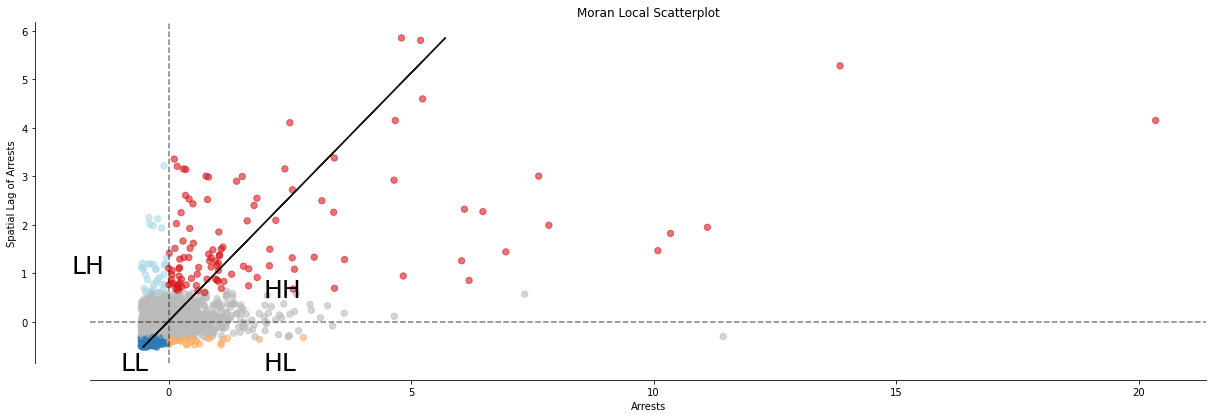

In [56]:
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Arrests")
ax.set_ylabel('Spatial Lag of Arrests')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

Interesting, okay the colored dots representcensus block groups that have a P-value less that 0.05 in each quadrant. Esentially, these are the statisticaly significantly, spatially autocorrelated locations.

FINALLY, our spatial autocorrelation map!!

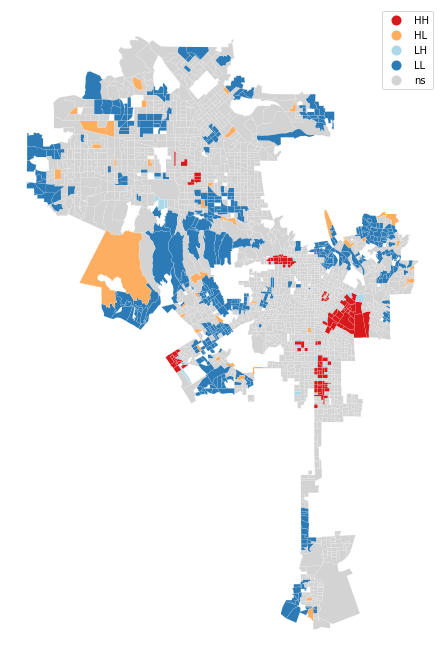

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [57]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf, p=0.05, ax=ax)
plt.show()

ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

plt.show()
plt.savefig('2020cluster.png')

The early onset of the COVID-19 pandemic had many people working from home and for the most part on "lockdown" for the first few months of the pandemic. Prior to this assessment, I thought we wouldn't see many arrests. However,thinking back to last year and the summer uprisings, this map makes a lot of sense as to where we see statistically significant clusters(highlighted in red) along Downtown LA, East LA, Venice, Hollywood, and South Central LA. Its also worth noting that the statistically high clusters we see on the map also happen to fall on top of poorer communities, with the exception of Venice highlighted in the far left. Venice lies on the westside, and while the westside is a more resourced and higher income area, there is also a high number houseless people with encampments in this area. 